<a href="https://colab.research.google.com/github/bettytan123/Sample-Size-Calculation/blob/main/Two_Continuous_Mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
############################################
## This script will simulate data from known statistical distirbutions; then estimate GAN and sample from it
## Final 2023 mar 3 2pm 
## Authors: Betty and Chris, ft David
## Date: February 2023
############################################

In [6]:
############################################
## Installations of required modules not default available on COLAB compute software stack
############################################
! pip install sdv --quiet
! pip install --upgrade scipy --quiet
! pip install sinfo --quiet
! pip install matplotlib==3.1.3 --quiet

In [7]:
########################
## Import dependency packages
########################

## Import SDV for GANs and sampling mechanisms, etc.
from sdv.tabular import CTGAN

## Import pandas for data structures
import pandas as pd

## Import numpy for numerical computing
import numpy as np

## Import scipy for statistical distirbution function 
import scipy

## For plotting
import matplotlib.pyplot as plt

## For timing
from time import time

## Random Numbers
import random

# For progress bars
from tqdm.notebook import tqdm, trange

# Do not display warnings (bad practice)
import warnings
warnings.filterwarnings("ignore")

# For CUDA enabled/accelerated computation on the GPU 
import torch

import matplotlib.pyplot as plt
import seaborn as sns

from io import StringIO

sns.set_style('darkgrid')

In [8]:
## Set seed of everything
np.random.seed(614)
torch.manual_seed(614)
random.seed(614)
scipy.stats.rv_continuous.random_state = 614

# Sample Size for Precision of a Continuous Normal Random Variable --- by Mathematical Theory


In [9]:
#####################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by Mathematical Theory
##
#####################################

In [10]:
scipy.stats.norm.ppf(q=0.025, loc=0, scale=1)

-1.9599639845400545

In [11]:
## Sample size by math
# q: Proportion of subjects that are in Group 1 (exposed
# Effect size (If μ1 = mean in Group 1 and μ0 = mean in Group 0, then E = μ1 - μ0.)
def samp_size_2mean(alpha, beta, q1, q0, effectsize, sigma):
    A = 1/q1 + 1/q0
    B = (scipy.stats.norm.ppf(q=alpha/2, loc=0, scale=1)+scipy.stats.norm.ppf(q=beta, loc=0, scale=1))**2 
    n = A*B/((effectsize/sigma)**2)
    return(n)



In [12]:
samp_size_2mean(alpha=0.05, beta=0.2, q1=0.5, q0=0.5, effectsize=0.2, sigma=1) #784


784.887973434909

In [13]:
#################################
##
## Sample Size for Precision of a Continuous Normal Random Variable --- by numerical simulation
##
################################

In [14]:
# x1 = np.random.normal(loc=2, scale=1, size=10)
# x2 = np.random.normal(loc=2, scale=1, size=10)
# ## Analyze generated/simulated data
# res = scipy.stats.ttest_ind(x1, x2, alternative='two-sided')               
    
# ## Extract the estimate and CI
# pval = res[1]
# r = res[0]

# pval = res[1]
# np.where(pval<0.05, 1, 0), int(pval < 0.05)

In [15]:
def twonorm_ci_samp_size(n, m1, m2, sd):
    ## Generate random data
    x1 = np.random.normal(loc=m1, scale=sd, size=n)
    x2 = np.random.normal(loc=m2, scale=sd, size=n)
    
    ## Analyze generated/simulated data
    # mu_vec = np.array([m1,m2])
    # sigma_matrix = np.array([sd, 0.0, 0.0, sd]).reshape((2,2))
    # x = scipy.stats.multivariate_normal.rvs(size=n, mean=mu_vec, cov=sigma_matrix)
    # x1, x2 = x[:,0], x[:,1]

    res  = scipy.stats.ttest_ind(x1, x2, alternative='two-sided', equal_var=False) 
    #res  = scipy.stats.ttest_rel(x1, x2, alternative='two-sided') 
    
    ## Extract the estimate and CI
    pval = res[1]
    #ttest = res[0]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({#'ttest': [ttest], 
                        'pval': [pval], 
                        'tag': [tag]})
    return(out)


In [16]:
twonorm_ci_samp_size(n=10, m1=0, m2=0.2, sd=1)

,pval,tag
0,0.458129,0


In [17]:
## Replicate above function number of simulation replicate times

# parameter available  
alpha=0.05
beta=0.2
q1=0.5
q0=0.5
effectsize=0.2
sigma=1
n = int(np.ceil(samp_size_2mean(alpha, beta, q1, q0, effectsize, sigma)))
m1 = 0
m2 = effectsize - m1
sd = 1


## Number simulation replicates
n_rep = 10000

## Simulate n_rep copies of sample size trials
sim_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    sim_out.append(twonorm_ci_samp_size(n, m1, m2, sd))

t1 = time()
runtime = t1 - t0

### Aggregate results into dataframe
sim_df = pd.concat(sim_out)

#Calculate means of each column in the array #axis means column mean 
sim_power = np.mean(sim_df, axis=0)
print(sim_power)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [18]:
## Collect the sample size simulation results into a single dataFrame
sim_results = pd.DataFrame({
    'runtime': [runtime],
    ## ?? 'correlation': [sim_means[0]],
    'pvalue': [sim_power[0]],
    'power': [sim_power[1]]
})

sim_results

,runtime,pvalue,power
0,30.38182,0.004782,0.978


# Sample size estimation by GAN simulation

In [19]:
import sys
 
path = 'logs.txt'
sys.stdout = open(path, 'w')

In [20]:
# model = CTGAN(verbose=True, epochs=200)
# model._model = model._build_model()
# model._set_random_state(42)

In [21]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_normal(pop_mu1, pop_mu2, pop_sd, pop_n):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x1 = np.random.normal(loc=pop_mu1, scale=pop_sd, size=pop_n)
    x2 = np.random.normal(loc=pop_mu2, scale=pop_sd, size=pop_n)
    x_pd = pd.DataFrame({'x1': x1, 'x2': x2})

    #   ## Convert vector to pandas dataFrame
    #x_pd = pd.DataFrame(x, columns=[f'x{i}' for i in range(x.shape[1])])

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    # CTGAN doesnt need to be seeded
    model = CTGAN(verbose=True, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out




In [22]:
# %%time
# %%capture output

## Parameters of normal parent distribution
mu1 = 0
mu2 = 0.2
sd = 1 
n = 10000

## Get the learned GAN model --- after training 
t0 = time()
train_gan = train_gan_model_normal(pop_mu1=mu1, pop_mu2= mu2, pop_sd=sd, pop_n=n)
t1 = time()
fit_time = t1 - t0
fit_time

575.8013336658478

In [23]:
with open('logs.txt') as file:
    lines = file.readlines()

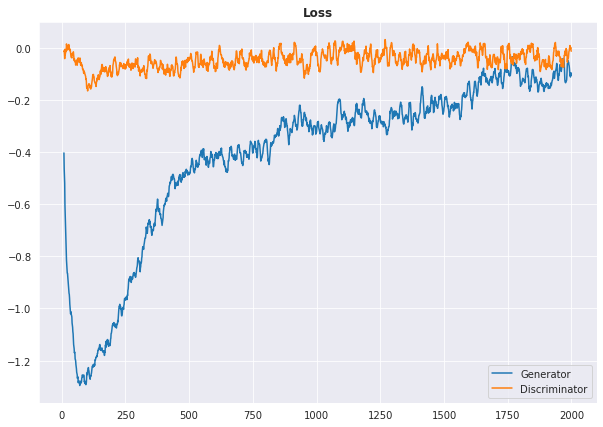

In [24]:
output = "".join(lines)
name = 'Loss'

output = StringIO(str(output))
window = 10

df = pd.read_csv(output, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# I think a regex would be better here
df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

plt.figure(figsize=(10,7))

# Plot with a moving average so it is less noisy
plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

plt.title(name, weight='bold')
plt.legend()
plt.show()

In [25]:
# logs = StringIO(str(output))
# window = 10 # window size for the moving average, window=1 gets you the original series

# df = pd.read_csv(logs, sep=",", names=['Epochs', 'Loss G', 'Loss D'])

# # I think a regex would be better here
# df['Loss G'] = df['Loss G'].apply(lambda x: float(x.split(':')[1]))
# df['Loss D'] = df['Loss D'].apply(lambda x: float(x.split(':')[1]))

# plt.figure(figsize=(10,7))

# # Plot with a moving average so it is less noisy
# plt.plot(df['Loss G'].rolling(window=window).mean(), label="Generator")
# plt.plot(df['Loss D'].rolling(window=window).mean(), label="Discriminator")

# plt.legend()
# plt.show()

In [26]:
# logs = str(output)

# # Messy way to do it, there are better ways
# logs = logs.split('\n')[0:-1]
# logs = [log.split(',') for log in logs]

# loss_generator = [float(log[1].split(':')[1].strip()) for log in logs]
# loss_discriminator = [float(log[2].split(':')[1].strip()) for log in logs]

# plt.figure(figsize=(10,7))

# plt.plot(loss_generator, label="Generator")
# plt.plot(loss_discriminator, label="Discriminator")

# plt.legend()
# plt.show()

In [27]:
model_ = train_gan[0]

In [28]:
model_.sample(num_rows=10000).mean(axis=0)

x1   -0.020527
x2    0.201964
dtype: float64

In [29]:
model_.get_parameters

<bound method BaseTabularModel.get_parameters of <sdv.tabular.ctgan.CTGAN object at 0x7fee610f15e0>>

In [30]:
## Summarize moments of the "parent distribution" used to simulate the synthetic GAN data
x_parent = train_gan[1]

x_parent.describe()

,x1,x2
count,10000.000000,10000.000000
mean,-0.009047,0.198402
std,0.998623,0.988229
min,-3.757413,-3.452711
25%,-0.682531,-0.468045
50%,-0.015767,0.197139
75%,0.669363,0.871859
max,3.710178,3.843226


In [31]:
## Parameter for specifying size of the simulated/synthetic data generated from the GAN
sim_n = int(np.ceil(samp_size_2mean(alpha=0.05, beta=0.2, q1=0.5, q0=0.5, effectsize=0.2, sigma=1)))

In [56]:
dat= model_.sample(num_rows=5)
dat

,x1,x2
0,0.138801,-0.103753
1,-0.441464,1.078656
2,0.347904,-0.864454
3,-1.435310,0.588378
4,-0.846191,0.464890


In [58]:
dat.iloc[:, 0]

0    0.138801
1   -0.441464
2    0.347904
3   -1.435310
4   -0.846191
Name: x1, dtype: float64

In [57]:
dat.iloc[:, 1]

0   -0.103753
1    1.078656
2   -0.864454
3    0.588378
4    0.464890
Name: x2, dtype: float64

In [50]:
dat["x1"]

0    2.387848
1   -0.965482
2   -1.429990
3   -0.948552
4    1.526686
Name: x1, dtype: float64

In [61]:
## Function to analyze data from the sampled model 
def twonorm_power_samp_size_gan(m, sim_n):
    ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
    dat = m.sample(num_rows=sim_n)

    ## Analyze generated/simulated data
    res = scipy.stats.ttest_ind(dat.iloc[:, 0],dat.iloc[:, 1], alternative='two-sided', equal_var=False) 
    ## Extract the p value and power
    pval = res[1]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate and the CI to the user
    # [] make it a list instead of scalar
    out = pd.DataFrame({'pval': [pval], 
                        'tag': [tag]})

    # Return the estimate and the CI to the user
    return(out)

In [62]:
## Replicate above function number of simulation replicate times

## Number simulation replicates
n_rep = 1000

## Simulate n_rep copies of sample size trials
gan_out = []

## Loop over number simulation replicates, storing results in list
t0 = time()

for i in trange(0, n_rep):
    gan_out.append(twonorm_power_samp_size_gan(m=model_, sim_n=sim_n))

t1 = time()
runtime = t1 - t0

## Aggregate results into dataframe
gan_df = pd.concat(gan_out)

## Calculate means of each column in the array #axis means column mean 
gan_power = np.mean(gan_df, axis=0)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [63]:
gan_power

pval    0.000238
tag     0.999000
dtype: float64

In [64]:
## Collect results of the GAN based sample size calculations
gan_results = pd.DataFrame({
    'runtime': [runtime],
    'pvalue': [gan_power[0]],
    'power': [gan_power[1]]
})

gan_results

,runtime,pvalue,power
0,30.030998,0.000238,0.999


In [ ]:
#########################################################################
##
##
## Below we investgiate finite sample properties of three methods for estimating sample size for a continuous CI from normal distribution
##    1) Theory or analytic formula
##    2) Simulation (from normal probability generating model)
##    3) Simulation (from GAN approximating parent normal probability generating model)
##
##
#########################################################################

In [69]:
###########################
## Create parameter grid
###########################
from itertools import product

def expand_grid(dictionary):
   return pd.DataFrame([row for row in product(*dictionary.values())], columns=dictionary.keys())

dictionary = {'alpha': [0.05], 
              'm1': [0.0],
              'm2': [0.2,0.3],
              'sd': [1],
              'effectsize': [0.2, 0.3], 
              'sigma' : [1],
              'q1' :[0.5],
              'q0' :[0.5],
              'beta': [0.05, 0.1, 0.15, 0.2]} # changed 0.01 -> 0.05 to reduce training time

param_df = expand_grid(dictionary)
param_df

,alpha,m1,m2,sd,effectsize,sigma,q1,q0,beta
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20
4,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.05
5,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.10
6,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.15
7,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.20
8,0.05,0.0,0.3,1,0.2,1,0.5,0.5,0.05
9,0.05,0.0,0.3,1,0.2,1,0.5,0.5,0.10


In [75]:
#################
## 1) Sample Size for Continuous CI by Theory or Analytic Formula
#################
samp_size_theory_list = []

for i in np.arange(param_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    n = samp_size_2mean(alpha=param_df.loc[i, 'alpha'], 
                        effectsize=param_df.loc[i, 'effectsize'],
                        sigma=param_df.loc[i, 'sigma'],
                        q1=param_df.loc[i, 'q1'], 
                        q0=param_df.loc[i, 'q0'],
                        beta=param_df.loc[i, 'beta']
                        )
    
    ## Round to largest integer
    n_ = str(np.round(np.ceil(n),0))
    ## Append sample size to list
    samp_size_theory_list.append(n_)

samp_size_theory_df = pd.concat([param_df, pd.Series(samp_size_theory_list)], axis=1)
samp_size_theory_df.columns = ['alpha','m1','m2','sd','q1','q0','beta','sigma','effectsize','n_theory']
samp_size_theory_df

,alpha,m1,m2,sd,q1,q0,beta,sigma,effectsize,n_theory
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05,1300.0
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10,1051.0
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15,898.0
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20,785.0
4,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.05,578.0
5,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.10,467.0
6,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.15,400.0
7,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.20,349.0
8,0.05,0.0,0.3,1,0.2,1,0.5,0.5,0.05,1300.0
9,0.05,0.0,0.3,1,0.2,1,0.5,0.5,0.10,1051.0


In [ ]:
########################
## 2) Sample Size for Continuous CI by Simulation from two Normal Distribution
########################

In [76]:
def twonorm_power_samp_size(n, m1, m2, sd):
  
    ## Generate random data
    x1 = np.random.normal(loc=m1, scale=sd, size=n)
    x2 = np.random.normal(loc=m2, scale=sd, size=n)
    
    ## Analyze generated/simulated data
    res  = scipy.stats.ttest_ind(x1, x2, alternative='two-sided', equal_var=False)
    
    ## Extract the estimate p value and tag 
    pval = res[1]
    tag = np.where(pval<0.05, 1, 0)
    # Return the estimate p value and tag to the out
    out = pd.DataFrame({'pval': [pval], 
                        'tag': [tag]})
    return(out)



In [94]:
##
## Replicate above function to compute expected CI width, for continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def twonorm_power_samp_size_sim(n, m1, m2, sd, n_rep):

    ## Simulate n_rep copies of sample size trials
    sim_out = []

    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in range(0, n_rep):
        sim_out.append(twonorm_power_samp_size(n=n, m1=m1, m2=m2, sd=sd))

    t1 = time()
    runtime = t1 - t0

    ### Aggregate results into dataframe
    sim_df = pd.concat(sim_out)

    ## Calculate means of each column in the array 
    sim_power = np.mean(sim_df, axis=0)
    print(sim_power)

    sim_results = pd.DataFrame({'runtime': [runtime],
                                'pvalue': [sim_power[0]],
                                'power': [sim_power[1]]
      })

    return(sim_results)

In [95]:
power= twonorm_power_samp_size_sim(n=10, m1=0, m2=0.1, sd=1, n_rep=10)

In [97]:
sim_results['power']

0    0.978
Name: power, dtype: float64

In [96]:
power['power'].values[0]

0.1

In [98]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_sim_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 10000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power = twonorm_power_samp_size_sim(n=int(float(samp_size_theory_df.loc[i, 'n_theory'])), 
                          m1=samp_size_theory_df.loc[i, 'm1'],
                          m2=samp_size_theory_df.loc[i, 'm2'],
                          sd=samp_size_theory_df.loc[i, 'sd'],
                          n_rep=n_rep)
    ## Round to largest integer
    power_ = power['power'].values[0]
    ## Append sample size to list
    samp_size_sim_list.append(power_)

t1 = time()
sim_time = t1-t0

## Compile results into dataFrame
samp_size_sim_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_sim_list)], axis=1)
samp_size_sim_df.columns = ['alpha','m1','m2','sd','q1','q0','beta','sigma','effectsize','n_theory','power_sim']
samp_size_sim_df

,alpha,m1,m2,sd,q1,q0,beta,sigma,effectsize,n_theory,power_sim
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05,1300.0,0.9990
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10,1051.0,0.9957
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15,898.0,0.9871
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20,785.0,0.9782
4,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.05,578.0,0.9268
5,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.10,467.0,0.8626
6,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.15,400.0,0.8053
7,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.20,349.0,0.7494
8,0.05,0.0,0.3,1,0.2,1,0.5,0.5,0.05,1300.0,1.0000
9,0.05,0.0,0.3,1,0.2,1,0.5,0.5,0.10,1051.0,1.0000


In [99]:
## Timing for the simulation experiments
sim_time

148.34009504318237

# Sample Size for Continuous CI by Generative Adversarial Network (GAN) from a (parent) Normal Distribution

In [102]:
## Function to train a GAN model to simulated normal data (with parms: mean, sd, n)
def train_gan_model_twonormal(pop_m1, pop_m2, pop_sd, pop_n):
    ## Set seed of everything
    np.random.seed(614)
    torch.manual_seed(614)
    random.seed(614)
    scipy.stats.rv_continuous.random_state = 614

    ## Simulate data as input to GAN
    x1 = np.random.normal(loc=pop_m1, scale=pop_sd, size=pop_n)
    x2 = np.random.normal(loc=pop_m1, scale=pop_sd, size=pop_n)
    
    #   ## Convert vector to pandas dataFrame
    x_pd = pd.DataFrame({'x1': x1, 'x2': x2})

    ## Feed the simulated data into SDV and sample synthetic data from the fitted GAN
    model = CTGAN(verbose=False, epochs=2000)

    ## Fit a GAN to the simulated data from above
    model.fit(x_pd)
    
    ## Return the learned model
    out = [model, x_pd]

    return out

In [103]:
##
## Replicate above function to compute expected power, for two continuous mean, at various parm values (mu, std, n) over number sim replicated (n_rep)
##
def twonorm_power_samp_size_gan(pop_n, pop_m1, pop_m2, pop_sd, sim_n, n_rep):

    ## Get the learned GAN model --- after training 
    t0 = time()
    train_gan = train_gan_model_twonormal(pop_m1=pop_m1, pop_m2=pop_m2, pop_sd=pop_sd, pop_n=pop_n)
    t1 = time()
    fit_time = t1 - t0
    #fit_time
    
    ## Extract learned GAN model
    model_ = train_gan[0]

    ## Function to analyze data from the sampled model 
    def twonorm_power_samp_size_gan(m, sim_n):
        ## Generate random data --- sampling from the trained GAN which approximates the normal probability generating function
        dat = m.sample(num_rows=sim_n)
        ## Analyze generated/simulated data
        res = scipy.stats.ttest_ind(dat.iloc[:, 0],dat.iloc[:, 1], alternative='two-sided', equal_var=False) 
        ## Extract the p value and power
        pval = res[1]
        tag = np.where(pval<0.05, 1, 0)
        # Return the estimate and the CI to the user
        # [] make it a list instead of scalar
        out = pd.DataFrame({'pval': [pval], 
                        'tag': [tag]})

        # Return the estimate and the CI to the user
        return(out)
        
    ##
    ## Replicate above function number of simulation replicate times
    ##

    ## Simulate n_rep copies of sample size trials
    gan_out = []
 
    ## Loop over number simulation replicates, storing results in list
    t0 = time()

    for i in trange(0, n_rep):
        gan_out.append(twonorm_power_samp_size_gan(m=model_, sim_n=sim_n))

    t1 = time()
    gan_time = t1 - t0

    ## Aggregate results into dataframe
    gan_df = pd.concat(gan_out)

    ## Calculate means of each column in the array #axis means column mean 
    gan_power = np.mean(gan_df, axis=0)
    
    gan_results = pd.DataFrame({
    'runtime': [runtime],
    'pvalue': [gan_power[0]],
    'power': [gan_power[1]]
     })

    return(gan_results)

In [105]:
##
## WARNING...notice very subtle difference between pop_n and sim_n
##
## "sim_n" should be set to size of theoretical sample size needed to obtain CI of expected width, given SD/alpha/mean
##
## "pop_n" can vary...larger values mean GAN parent dist is more likely converge in dist to population model, smaller values reduce likelihood convergence in dist
##     --- larger values can also substantially increase training time for the GAN model
##

t0 = time()

tmp = twonorm_power_samp_size_gan(pop_n=1000, 
                      pop_m1=0, 
                      pop_m2=0.2,
                      pop_sd=1, 
                      sim_n=int(np.ceil(samp_size_2mean(alpha=0.05, beta=0.2, q1=0.5, q0=0.5, effectsize=0.2, sigma=1))),
                      n_rep=1000)

t1 = time()

[tmp, t1-t0]

  0%|          | 0/1000 [00:00<?, ?it/s]

[     runtime    pvalue  power
 0  30.030998  0.000988  0.999, 108.72122597694397]

In [107]:
## Loop over theoretical table, to use simulation to understand relationship between (n, mu, std, n_rep) etc.
samp_size_gan_list = []

## 1000 simulation replicates; reduces computational burden
n_rep = 1000

t0 = time()

for i in np.arange(samp_size_theory_df.shape[0]):
    ## Compute sample size at particular parameter condiguration
    power = twonorm_power_samp_size_gan(pop_n=1000, 
                      pop_m1=samp_size_theory_df.loc[i, 'm1'],
                      pop_m2=samp_size_theory_df.loc[i, 'm2'],
                      pop_sd=samp_size_theory_df.loc[i, 'sd'],
                      sim_n=int(float(samp_size_theory_df.loc[i, 'n_theory'])),
                      n_rep=n_rep)
    ## Round to largest integer
    power_ = power['power'].values[0]
    ## Append sample size to list
    samp_size_gan_list.append(power_)


t1 = time()
gan_time = t1-t0

## Compile results into dataFrame
samp_size_gan_df = pd.concat([samp_size_theory_df, pd.Series(samp_size_gan_list)], axis=1)
samp_size_gan_df.columns = ['alpha','m1','m2','sd','q1','q0','beta','sigma','effectsize','n_theory','power_gan']
samp_size_gan_df

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

,alpha,m1,m2,sd,q1,q0,beta,sigma,effectsize,n_theory,power_gan
0,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.05,1300.0,1.000
1,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.10,1051.0,1.000
2,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.15,898.0,1.000
3,0.05,0.0,0.2,1,0.2,1,0.5,0.5,0.20,785.0,0.999
4,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.05,578.0,0.980
5,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.10,467.0,0.955
6,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.15,400.0,0.916
7,0.05,0.0,0.2,1,0.3,1,0.5,0.5,0.20,349.0,0.862
8,0.05,0.0,0.3,1,0.2,1,0.5,0.5,0.05,1300.0,1.000
9,0.05,0.0,0.3,1,0.2,1,0.5,0.5,0.10,1051.0,1.000


In [108]:
gan_time

1405.9275517463684

In [ ]:
##############################################
##
## Properties/info on the Jupyter Notebook session
##
#############################################

In [109]:
## Date/time
from datetime import datetime
str(datetime.today()).split()[0]

'2023-03-19'

In [110]:
## Session Info
from sinfo import sinfo
sinfo()

In [ ]:
## Jupyter version
!jupyter --version

Selected Jupyter core packages...
IPython          : 7.9.0
ipykernel        : 5.3.4
ipywidgets       : 7.7.1
jupyter_client   : 6.1.12
jupyter_core     : 5.2.0
jupyter_server   : not installed
jupyterlab       : not installed
nbclient         : 0.7.2
nbconvert        : 6.5.4
nbformat         : 5.7.3
notebook         : 6.3.0
qtconsole        : not installed
traitlets        : 5.7.1


In [111]:
## Python version
!python --version